In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import Adam, SGD
import shutil
!pip install tensorflow

In [ ]:
# GPU kontrolü
if tf.config.list_physical_devices('GPU'):
    print("GPU kullanılıyor.")
else:
    print("GPU kullanılamıyor. Eğitim CPU üzerinde yapılacak.")

GPU kullanılamıyor. Eğitim CPU üzerinde yapılacak.


In [ ]:
# Verilen yol
base_dir = '/content/drive/MyDrive/YapaySinirAglariFinal/FaceMaskDetDT/data/'
categories = ['with_mask', 'without_mask']
output_dirs = ['train', 'validation', 'test']
split_ratios = {'train': 0.8, 'validation': 0.2}

In [ ]:
# Fonksiyon: Dosyaları yeni hedef klasörlere ayırma
def split_and_copy_files(src_dir, dest_dir, category, split_ratios):
    # Dosyaları listeleme
    files = [os.path.join(src_dir, f) for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    train_files, test_files = train_test_split(files, test_size=1 - split_ratios['train'], random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=split_ratios['validation'], random_state=42)

    # Hedef klasörlere ayırma
    for split, split_files in zip(output_dirs, [train_files, val_files, test_files]):
        split_path = os.path.join(dest_dir, split, category)
        os.makedirs(split_path, exist_ok=True)
        for file in split_files:
            shutil.copy(file, split_path)
        print(f"{split} klasörüne {len(split_files)} dosya taşındı ({category}).")

# Fonksiyon: Bölünmüş dosyaları kontrol etme
def check_split_integrity(dest_dir, categories, output_dirs):
    for split in output_dirs:
        for category in categories:
            split_path = os.path.join(dest_dir, split, category)
            count = len(os.listdir(split_path)) if os.path.exists(split_path) else 0
            print(f"{split_path} klasöründe {count} dosya var.")

# İşlem
for category in categories:
    src_path = os.path.join(base_dir, category)
    split_and_copy_files(src_path, base_dir, category, split_ratios)

# Son Kontrol
check_split_integrity(base_dir, categories, output_dirs)


train klasörüne 2980 dosya taşındı (with_mask).
validation klasörüne 596 dosya taşındı (with_mask).
test klasörüne 149 dosya taşındı (with_mask).
train klasörüne 3062 dosya taşındı (without_mask).
validation klasörüne 612 dosya taşındı (without_mask).
test klasörüne 154 dosya taşındı (without_mask).
/content/drive/MyDrive/YapaySinirAglariFinal/FaceMaskDetDT/data/train/with_mask klasöründe 2980 dosya var.
/content/drive/MyDrive/YapaySinirAglariFinal/FaceMaskDetDT/data/train/without_mask klasöründe 3062 dosya var.
/content/drive/MyDrive/YapaySinirAglariFinal/FaceMaskDetDT/data/validation/with_mask klasöründe 596 dosya var.
/content/drive/MyDrive/YapaySinirAglariFinal/FaceMaskDetDT/data/validation/without_mask klasöründe 612 dosya var.
/content/drive/MyDrive/YapaySinirAglariFinal/FaceMaskDetDT/data/test/with_mask klasöründe 149 dosya var.
/content/drive/MyDrive/YapaySinirAglariFinal/FaceMaskDetDT/data/test/without_mask klasöründe 154 dosya var.


In [ ]:
# Fonksiyon: Klasörleri DataFrame'e dönüştürme
def create_dataframe_from_folders(base_dir, categories, output_dirs):
    data = []
    for split in output_dirs:
        for category in categories:
            split_path = os.path.join(base_dir, split, category)
            label = categories.index(category)  # Kategoriye göre etiket (0 veya 1)
            if os.path.exists(split_path):
                files = [os.path.join(split_path, f) for f in os.listdir(split_path) if os.path.isfile(os.path.join(split_path, f))]
                for file in files:
                    data.append({'file_path': file, 'label': label, 'split': split})
    return pd.DataFrame(data)

# DataFrame oluşturma
df = create_dataframe_from_folders(base_dir, categories, output_dirs)

# İlk 5 satırı kontrol etme
print(df.head())

# DataFrame'in özet bilgisi
print(df['split'].value_counts())
print(df['label'].value_counts())

                                           file_path  label  split
0  /content/drive/MyDrive/YapaySinirAglariFinal/F...      0  train
1  /content/drive/MyDrive/YapaySinirAglariFinal/F...      0  train
2  /content/drive/MyDrive/YapaySinirAglariFinal/F...      0  train
3  /content/drive/MyDrive/YapaySinirAglariFinal/F...      0  train
4  /content/drive/MyDrive/YapaySinirAglariFinal/F...      0  train
split
train         6042
validation    1208
test           303
Name: count, dtype: int64
label
1    3828
0    3725
Name: count, dtype: int64


In [ ]:
# Veri setini eğitim (%80) ve test (%20) olarak ayırma
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Eğitim+Validasyon setini daha sonra eğitim (%80) ve validasyon (%20) olarak ayıracağız
len(train_val_df), len(test_df)

(6042, 1511)

In [ ]:
# Eğitim ve validasyon setlerini ayırma (%80 eğitim, %20 validasyon)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)

# Convert 'label' column to string type before creating the generator
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Veri arttırma (data augmentation) işlemi için ImageDataGenerator
image_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data generator'lar için hazırlık
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

len(train_df), len(val_df)

Found 4833 validated image filenames belonging to 2 classes.
Found 1209 validated image filenames belonging to 2 classes.
Found 1511 validated image filenames belonging to 2 classes.


(4833, 1209)

In [ ]:
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# DenseNet121 Modeli hazırlama
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Tüm katmanları dondurma
for layer in base_model_densenet.layers:
    layer.trainable = False

# Son 50 katmanı çözme
for layer in base_model_densenet.layers[-40:]:
    layer.trainable = True

x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions_densenet = Dense(1, activation='sigmoid')(x)
model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions_densenet)

#-----------------------------------MOBILENET MODEL KATMANI----------------------------------------

# MobileNet Modeli hazırlama
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Tüm katmanları dondurma
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Son 50 katmanı çözme
for layer in base_model_mobilenet.layers[-40:]:
    layer.trainable = True

# MobileNet Model oluşturma
model_mobilenet = Sequential([
    base_model_mobilenet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# DenseNet121 Model derleme
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)
model_densenet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks tanımlama
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

# DenseNet121 Model eğitimi
history_densenet = model_densenet.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 51/152 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.8497 - loss: 0.3492

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 88s 378ms/step - accuracy: 0.9183 - loss: 0.2007 - val_accuracy: 0.9901 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 224ms/step - accuracy: 0.9928 - loss: 0.0307 - val_accuracy: 0.9835 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.9867 - loss: 0.0465 - val_accuracy: 0.9942 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.9916 - loss: 0.0292 - val_accuracy: 0.9926 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.9959 - loss: 0.0150 - val_accuracy: 0.9942 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.9909 - loss: 0.0303 - val_accuracy: 0.9942 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.9903 -

In [ ]:
try:
    model_densenet.save('/content/drive/MyDrive/YapaySinirAglariFinal/densenet_model.h5')
    print("Model başarıyla kaydedildi!")
except Exception as e:
    print("Model kaydedilemedi!!!!!")

Model başarıyla kaydedildi!


In [ ]:
# MobileNet Model eğitimi
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)
model_mobilenet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 63s 286ms/step - accuracy: 0.9225 - loss: 0.1994 - val_accuracy: 0.9222 - val_loss: 0.7608 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.9794 - loss: 0.0579 - val_accuracy: 0.9950 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.9851 - loss: 0.0461 - val_accuracy: 0.9975 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.9885 - loss: 0.0401 - val_accuracy: 0.9744 - val_loss: 0.1465 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.9872 - loss: 0.0417 - val_accuracy: 0.9876 - val_loss: 0.0724 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.9942 - loss: 0.0249 - val_accuracy: 0.9942 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.9937 -

In [ ]:
try:
    model_mobilenet.save('/content/drive/MyDrive/YapaySinirAglariFinal/history_mobilenet.h5')
    print("Model başarıyla kaydedildi!")
except Exception as e:
    print("Model kaydedilemedi!")

Model başarıyla kaydedildi!


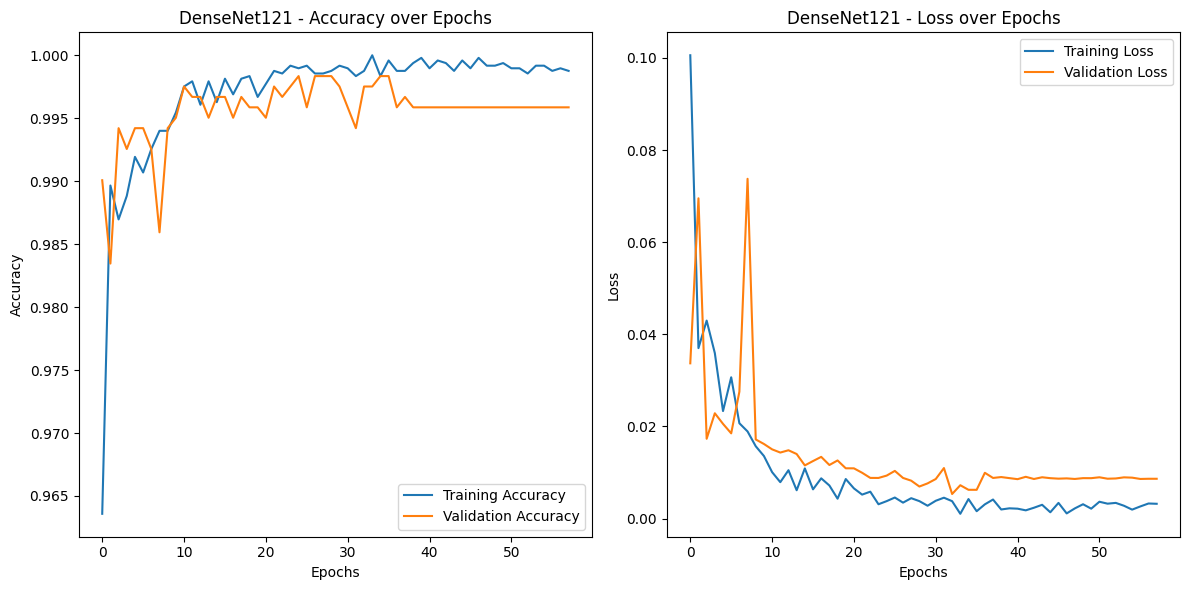

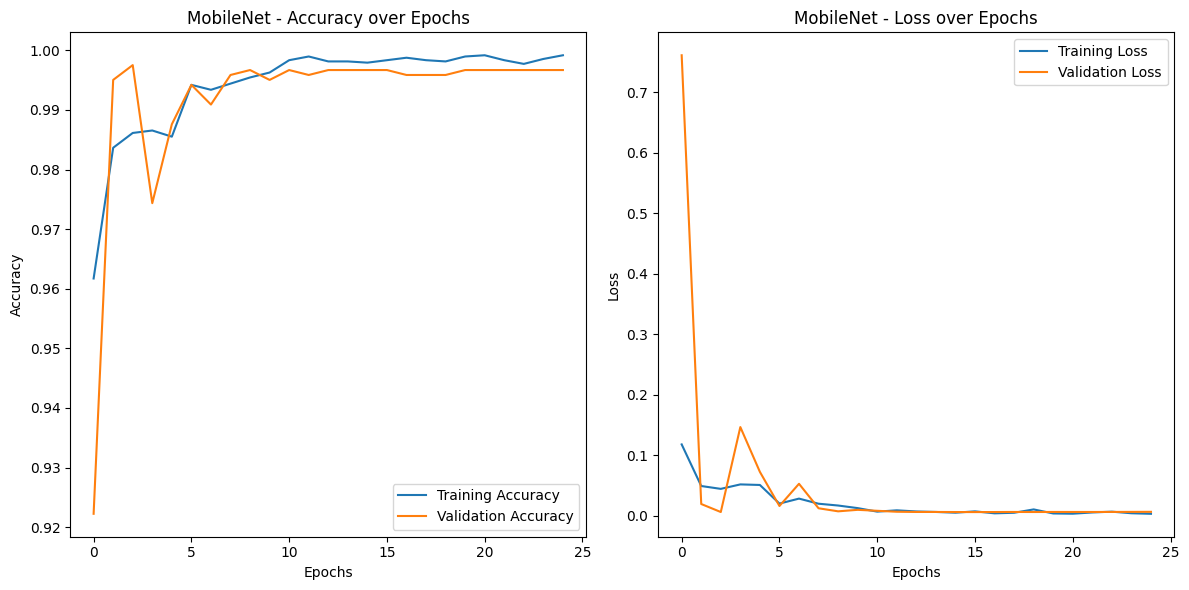

In [ ]:
# Eğitim/validasyon accuracy ve loss grafikleri
def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))
    # Accuracy grafiği
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Grafikleri çizdirme
plot_training_history(history_densenet, 'DenseNet121')
plot_training_history(history_mobilenet, 'MobileNet')

# **Densenet121 ve MobileNet Modelleri Grafik Yorumları**

---



# **DenseNet121 Modeli**

* **Densenet121 modeli üzerindeki Validation gözlemim:**

Eğitim doğruluğu (mavi çizgi), hızlı bir şekilde artıyor ve neredeyse 1.0 (yani %100) doğruluğa ulaşıyor.
Doğrulama doğrusu (turuncu çizgi), genelde sabit bir artış gösteriyor ancak daha düşük bir değerde stabil hale geliyor.
Eğitim doğruluğu ile doğrulama doğruluğu arasında bir fark var. Eğitim doğruluğu çok yüksekken doğrulama doğrusu bu kadar yüksek değil.

* **Densenet121 modeli üzerindeki Loss(Kayıp) gözlemim:**

Eğitim kaybı (mavi çizgi), hızlı bir şekilde düşüyor ve düşük bir seviyede sabitleniyor.
Doğrulama kaybı (turuncu çizgi), başlangıçta dalgalanıyor ancak bir süre sonra stabil hale geliyor.
Eğitim ve doğrulama kayıpları arasında belirgin bir fark var. Eğitim kaybı oldukça düşükken, doğrulama kaybı daha yüksek bir seviyede sabitlenmiş.


Bu durum grafik üzerinde overfitting'i destekliyor. Eğitim verisi üzerinde modelin hataları minimuma indirilmişken doğrulama verisinde bu kadar iyi bir performans gösterilemiyor. Model eğitim verisini ezberlemiş gibi duruyor ve bu nedenle yeni verilere genelleme yaparken zorlanıyor.


# **MobileNetV1 Modeli**
* **Validasyon Grafiği Üzerindeki Gözlemim;**

Eğitim doğruluğu (mavi çizgi), hızla artıyor ve yaklaşık 0.995 seviyesine ulaşıyor. Doğrulama doğrusu (turuncu çizgi) de benzer bir şekilde artıyor ve eğitim doğruluğu ile çok yakın seyrediyor.
İlk birkaç epoch boyunca doğrulama doğruluğunda bir miktar dalgalanma var ancak daha sonra stabil hale geliyor.

Sonuç olarak, eğitim ve doğrulama doğruluklarının birbirine çok yakın olması modelin overfitting yapmadığını ve iyi bir genelleme kapasitesine sahip olduğunu gösteriyor. Doğruluk oranlarının yüksek olması, modelin hem eğitim verisi hem de doğrulama verisi üzerinde iyi performans sergilediğini gösteriyor. İlk birkaç epoch’taki dalgalanmalar modelin öğrenme sürecinin bir parçası olarak değerlendirilebilir.

* **Loss (Kayıp) Grafiği Üzerindeki Gözlemim;**

Eğitim kaybı (mavi çizgi), hızla düşüyor ve düşük bir seviyede sabitleniyor. Doğrulama kaybı (turuncu çizgi) başlangıçta dalgalanma gösterse de benzer bir şekilde düşerek düşük bir seviyede sabitleniyor.
Eğitim ve doğrulama kayıpları arasında belirgin bir fark yok ikisi de düşük değerlere ulaşıyor.
Sonuç olarak; eğitim ve doğrulama kayıplarının birbirine yakın olması, modelin hem eğitim verisine hem de doğrulama verisine uygun şekilde öğrendiğini gösteriyor. Bu underfitting (yetersiz öğrenme) ya da overfitting (aşırı öğrenme) sorunu olmadığına işaret ediyor. Kayıp değerlerinin düşük olması modelin hatalarının az olduğunu ve etkili bir şekilde öğrendiğini gösteriyor.


---

# **Genel Durum Değerlendirmesi**


Densenet121 Modelin eğitimi, doğrulama seti üzerindeki performansa göre değerlendirilirdiğinde overfitting Sorunu ile karşılaşılmaktadır. Eğitim doğruluğu ile doğrulama doğruluğu arasındaki fark ve doğrulama kaybının daha yüksek olması, modelin overfitting yaptığını gösteriyor.

Performansın İyileştirilmesi İçin; düzenlileştirme teknikleri kullanılabilir, dropout ya da L2 regularization gibi yöntemler overfitting'i azaltabilir.
Daha Fazla Veri Ekleme model öğrenimi açısından önemli olabilir, Modelin daha iyi genelleme yapabilmesi için eğitim ve doğrulama setlerinin genişletilmesi iyi olabilir.

Sonuç olarak, model iyi bir başlangıç noktası yakalamış ancak overfitting sorunu, uzun vadeli kullanım için performansını sınırladığı görülmektedir.

MobileNet modeli, eğitim ve doğrulama seti üzerinde yüksek doğruluk oranlarına ve düşük kayıp değerlerine ulaşmış görünüyor. Bu durum modelin genel performansının iyi olduğunu ve genelleme kapasitesinin yüksek olduğunu gösteriyor.
Denge durumuna bakıldığında, eğitim ve doğrulama eğrilerinin birbirine yakın olması, modelin hem eğitim hem de doğrulama verisine benzer şekilde performans gösterdiğini ortaya koyuyor. Bu modelin iyi bir denge yakaladığını ve gerçek dünya verisi üzerinde de benzer sonuçlar üretebileceğini düşündürüyor.
Grafikteki dalgalanmalar, özellikle doğrulama doğruluğu ve kaybında ilk birkaç epoch boyunca görülen dalgalanmalar normal gibi duruyor. Bu durum modelin veriyi öğrenme sürecinin doğal bir parçasıdır. Daha sonraki epoch’larda bu dalgalanmalar azalarak stabil bir duruma ulaşıyor.

Eğitim ve doğrulama seti üzerinde zaten iyi bir performans gösteren model için daha fazla iyileştirmeye gerek olmayabilir.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix,
    roc_curve, auc
)
from tensorflow.keras.models import load_model
import pandas as pd  # Import pandas
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#modellerin yüklenmesi

model_densenet = load_model('/content/drive/MyDrive/YapaySinirAglariFinal/densenet_model.h5')
model_mobilenet = load_model('/content/drive/MyDrive/YapaySinirAglariFinal/history_mobilenet.h5')

# test_df should be a DataFrame, not a string
# Assuming you have a similar structure to your training data,
# you'll need to create a DataFrame for your test data.
# Here's an example, assuming your test data is organized into
# 'with_mask' and 'without_mask' subfolders within the 'test' directory:

test_dir = '/content/drive/MyDrive/YapaySinirAglariFinal/FaceMaskDetDT/data/test'
categories = ['with_mask', 'without_mask']

test_data = []
for category in categories:
    category_path = os.path.join(test_dir, category)
    label = categories.index(category)  # Kategoriye göre etiket (0 veya 1)
    if os.path.exists(category_path):
        files = [os.path.join(category_path, f) for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        for file in files:
            test_data.append({'file_path': file, 'label': label})

test_df = pd.DataFrame(test_data)  # Create DataFrame for test data
test_df['label'] = test_df['label'].astype(str) # Convert label column to string

image_size = (128, 128)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 303 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 87s 8s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step
Model: DenseNet121
Accuracy: 1.0000
F1-Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Specificity: 1.0000
AUC: 1.0000


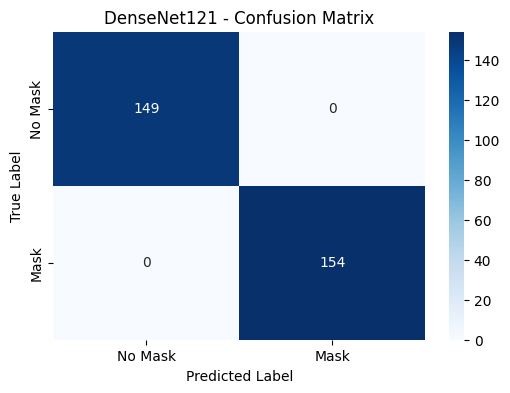

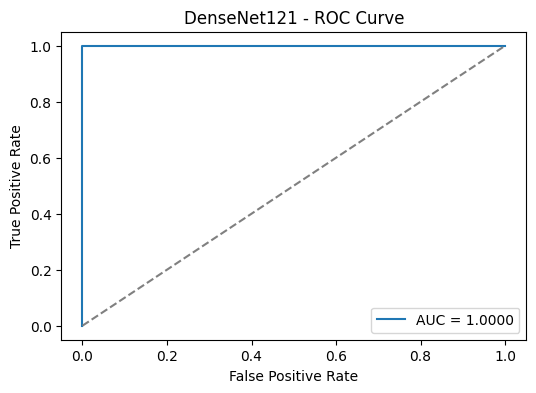

Model: MobileNet
Accuracy: 0.9208
F1-Score: 0.9155
Precision: 1.0000
Recall: 0.8442
Specificity: 1.0000
AUC: 0.9990


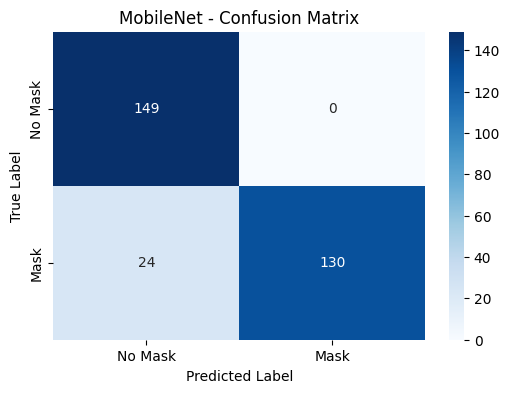

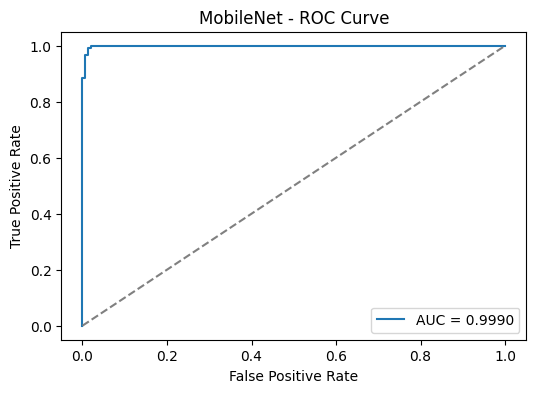

In [ ]:
# Test veri setinden gerçek etiketleri al
y_true = test_generator.classes

# DenseNet Modeli ile tahmin yap
y_pred_densenet_prob = model_densenet.predict(test_generator)
y_pred_densenet = (y_pred_densenet_prob > 0.5).astype(int)

# MobileNet Modeli ile tahmin yap
y_pred_mobilenet_prob = model_mobilenet.predict(test_generator)
y_pred_mobilenet = (y_pred_mobilenet_prob > 0.5).astype(int)

# Performans metrikleri hesaplama fonksiyonu
def evaluate_model(y_true, y_pred, y_pred_prob, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Confusion Matrix hesapla
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # Özgüllük

    # ROC Eğrisi ve AUC hesapla
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    print(f"Model: {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"AUC: {roc_auc:.4f}")

    # Confusion Matrix Görselleştirme
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # ROC Eğrisini Görselleştirme
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.show()

# DenseNet121 Model Değerlendirmesi
evaluate_model(y_true, y_pred_densenet, y_pred_densenet_prob, "DenseNet121")

# MobileNet Model Değerlendirmesi
evaluate_model(y_true, y_pred_mobilenet, y_pred_mobilenet_prob, "MobileNet")


# Test Verisi Üzerinde Model Performans Değerlendirmeleri

* **DenseNet121 Model Performans Analizi**

DenseNet121 modeli derin öğrenme alanında yaygın olarak kullanılan bir mimari olup, sınıflandırma görevlerinde güçlü performansıyla bilinir. Bu modelin "Maske Var / Maske Yok" sınıflandırma görevindeki sonuçları aşağıdaki gibidir;

Başlıca Performans Metrikleri:
Doğruluk (Accuracy): 1.0000
Model tüm verileri doğru bir şekilde sınıflandırmıştır. Bu, modelin hem eğitim hem de test verilerinde hatasız çalıştığını göstermektedir.

F1-Skoru: 1.0000
F1-skoru, modelin hassasiyet (precision) ve duyarlılığı (recall) dengeli bir şekilde optimize ettiğini ve mükemmel bir sınıflandırma performansı sağladığını göstermektedir.

Hassasiyet (Precision): 1.0000
Modelin pozitif sınıf tahminlerinin tamamı doğru olup, "Maske Var" olarak tahmin edilen tüm örneklerin gerçekten doğru olduğu görülmektedir.

Duyarlılık (Recall): 1.0000
Model, pozitif sınıfa ait tüm örnekleri doğru bir şekilde tespit etmiştir. "Maske Var" sınıfını kaçırmadan yakalayabilmiştir.

Özgüllük (Specificity): 1.0000
Negatif sınıfa (Maske Yok) ait tüm örnekler doğru sınıflandırılmıştır. Yanlış negatif oranı sıfırdır.

Confusion Matrix (Karmaşıklık Matrisi): Hiçbir Yanlış sınıflandırma bulunmamaktadır.
Confusion matrix'e göre:

"Maske Yok" sınıfına ait 149 örnek doğru bir şekilde sınıflandırılmıştır.
"Maske Var" sınıfına ait 154 örnek doğru bir şekilde sınıflandırılmıştır.

ROC Eğrisi grafiğine baktığımızda, (Receiver Operating Characteristic) eğrisi, modelin farklı eşik değerlerinde pozitif sınıfları ne kadar iyi ayırt ettiğini göstermektedir. Modele ait ROC eğrisi grafiği mükemmel bir şekilde maksimum performansı göstermektedir.

Modelin Genel Değerlendirmesi:
DenseNet121 modeli bu sınıflandırma görevinde olağanüstü bir başarı göstermiştir. Doğruluk, hassasiyet, duyarlılık ve özgüllük gibi tüm temel metrikler 1.0000 değerine ulaşmıştır. Model ne eğitim ne de test verilerinde hata yapmamıştır. ROC eğrisinin altındaki alanın (AUC) 1.0 olması, modelin pozitif ve negatif sınıfları mükemmel bir şekilde ayırt ettiğini göstermektedir.

Olası riskler ve dikkat edilmesi gereken noktalar bulunmaktadır. Bunlar; Overfitting, bu sonuçlar modelin eğitim ve test verilerinde mükemmel performans sergilediğini göstermektedir. Ancak bu durum, modelin veri setine fazla uyum sağlamış (overfitting) olabileceğini düşündürtebilir. Modelin genel performansını değerlendirmek için farklı veri setleri veya çapraz doğrulama yöntemleri kullanılmalıdır.
Veri çeşitliliği, sonuçların genelleştirilebilir olması için veri setinin yeterince çeşitli ve gerçek dünya örneklerini temsil ediyor olması önemlidir. Aksi takdirde model yeni verilerde beklenen performansı göstermeyebilir.
Sonuç olarak DenseNet121 modeli, bu çalışmada mükemmel sonuçlar elde etmiş ve görevini eksiksiz bir şekilde yerine getirmiştir.


---

* **MobileNet Model Performans Analizi**

MobileNet modeli, düşük kaynak kullanımı ve yüksek performansı nedeniyle sınıflandırma görevlerinde yaygın olarak kullanılan bir mimaridir. Bu çalışmada modelin "Maske Var / Maske Yok" sınıflandırma görevindeki sonuçları aşağıdaki gibidir;

Başlıca Performans Metrikleri:
Doğruluk (Accuracy): 0.9208
Model genel doğruluk açısından oldukça başarılıdır. Tüm örneklerin yaklaşık %92'sini doğru sınıflandırmıştır.

F1-Skoru: 0.9155
F1-skoru, modelin hem hassasiyet (precision) hem de duyarlılık (recall) metriklerinde dengeli bir performans sergilediğini göstermektedir.

Hassasiyet (Precision): 1.0000
Model, "Maske Var" olarak tahmin ettiği tüm örneklerde %100 doğruluk sağlamıştır.

Duyarlılık (Recall): 0.8442
Model, "Maske Var" sınıfına ait örneklerin yaklaşık %84'ünü doğru şekilde tespit etmiştir. Ancak kalan %16'lık bir kısmı atlanmıştır.

Özgüllük (Specificity): 1.0000
Negatif sınıfa (Maske Yok) ait tüm örnekler doğru şekilde sınıflandırılmıştır. Hiçbir yanlış negatif bulunmamaktadır.

AUC (Area Under Curve): 0.9990
ROC eğrisi altındaki alan modelin pozitif ve negatif sınıfları ayırt etme performansının neredeyse mükemmel olduğunu göstermektedir.

Confusion Matrix (Karmaşıklık Matrisi): Bu sonuçlar modelin "Maske Var" sınıfını ayırt etme konusunda küçük bir hata payı olduğunu göstermektedir.
"Maske Yok" sınıfına ait 149 örnek doğru sınıflandırılmıştır. Hiçbir yanlış pozitif bulunmamaktadır.
"Maske Var" sınıfına ait 130 örnek doğru sınıflandırılmış, ancak 24 örnek yanlış sınıflandırılmıştır (False Negative).

ROC Eğrisi grafiğine baktığımızda; modelin ROC eğrisi, yüksek bir eğime sahiptir ve pozitif sınıfı ayırt etme performansının oldukça güçlü olduğunu ortaya koymuştur.
AUC (Area Under Curve) değeri 0.9990 çıkmış olup modelin sınıflandırma performansının mükemmele yakın olduğunu doğrulamaktadır.

Modelin Genel Değerlendirmesi:
MobileNet modeli bu sınıflandırma görevinde genel olarak oldukça iyi bir performans göstermiştir. Doğruluk, hassasiyet ve AUC gibi temel metrikler oldukça yüksektir. Ancak modelin "Maske Var" sınıfını tespit etme konusunda (recall = %84.42) bazı eksiklikleri bulunmaktadır. Bu durum, özellikle "Maske Var" sınıfındaki hataları azaltma stratejilerinin değerlendirilmesi gerektiğini göstermektedir.

Olası riskler ve dikkat edilmesi gereken noktalar bulunmaktadır. Bunlar, duyarlılığın Artırılması; Model "Maske Var" sınıfında bazı hatalar yapmıştır. Bu sınıfta daha iyi performans elde etmek için, örnek sayısını artırarak veya sınıf dengesizliği varsa veri çoğaltma (data augmentation) teknikleri kullanılabilir. Overfitting Kontrolü; Model, eğitim verisine fazla uyum sağlamış olabilir. Bu durumu kontrol etmek için çapraz doğrulama (cross-validation) yapılmalı veya model farklı veri setlerinde tekrar tekrar test edilmelidir.
Sonuç olarak MobileNet modeli, sınıflandırma görevinde oldukça başarılı bir performans sergilemiş, özellikle negatif sınıfları (Maske Yok) doğru şekilde ayırt etmiştir. Ancak pozitif sınıf (Maske Var) için duyarlılığın artırılması, genel model performansını daha da iyileştirebilir. Modelin genelleştirilebilirliğini doğrulamak adına ek testler yapılması yapılabilir öngörüsü bulunmaktadır.